# TrainSelPy: Simplified Demonstration Examples

This notebook provides simplified examples of the core features in TrainSelPy. It demonstrates key concepts without the complexity of the full comprehensive vignette, focusing on functionality that works reliably with the current implementation.

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# Import TrainSelPy components
from trainselpy import (
    make_data,
    train_sel,
    set_control_default,
    dopt,
    maximin_opt
)

# For visualization
%matplotlib inline
plt.style.use('ggplot')

## 1. Simple Subset Selection (Unordered)

Let's start with a basic example of selecting an optimal subset using D-optimality.

In [2]:
# Create a small test dataset
n_samples = 100
n_features = 20

np.random.seed(42)  # For reproducibility

# Create a marker matrix (simulated genotypes)
M = np.random.choice([-1, 0, 1], size=(n_samples, n_features), p=[0.25, 0.5, 0.25])

# Create a relationship matrix (genomic relationships)
K = np.dot(M, M.T) / n_features

# Add a small value to the diagonal to ensure positive definiteness
K += np.eye(n_samples) * 1e-6

print(f"Created dataset with {n_samples} samples and {n_features} features")

# Create the TrainSel data object
ts_data = make_data(M=M)

# For D-optimality, we need to add the feature matrix to the data
ts_data["FeatureMat"] = M

# Set control parameters (limited iterations for example)
control = set_control_default()
control["niterations"] = 30  # Reduced for demonstration
control["npop"] = 100

# Run the selection algorithm with D-optimality
result = train_sel(
    data=ts_data,
    candidates=[list(range(n_samples))],  # Select from all samples
    setsizes=[10],                      # Select 10 samples
    settypes=["UOS"],                  # Unordered set
    stat=dopt,                         # Use D-optimality
    control=control,
    verbose=True
)

print(f"\nSelected {len(result.selected_indices[0])} samples:")
print(f"Selected indices: {result.selected_indices[0]}")
print(f"Final fitness (D-optimality): {result.fitness:.6f}")

Created dataset with 100 samples and 20 features
Starting TrainSelPy optimization
Starting GA with population size 100
Initial best fitness: -207.91094921929118
Generation 0: Best fitness = -207.82968247802694
Generation 10: Best fitness = -206.65519676344877
Generation 20: Best fitness = -205.85192860684785
Optimization completed in 0.60 seconds
Final fitness: -205.85192860684785

Selected 10 samples:
Selected indices: [2, 18, 26, 33, 44, 54, 55, 66, 87, 93]
Final fitness (D-optimality): -205.851929


### Visualizing the Selection

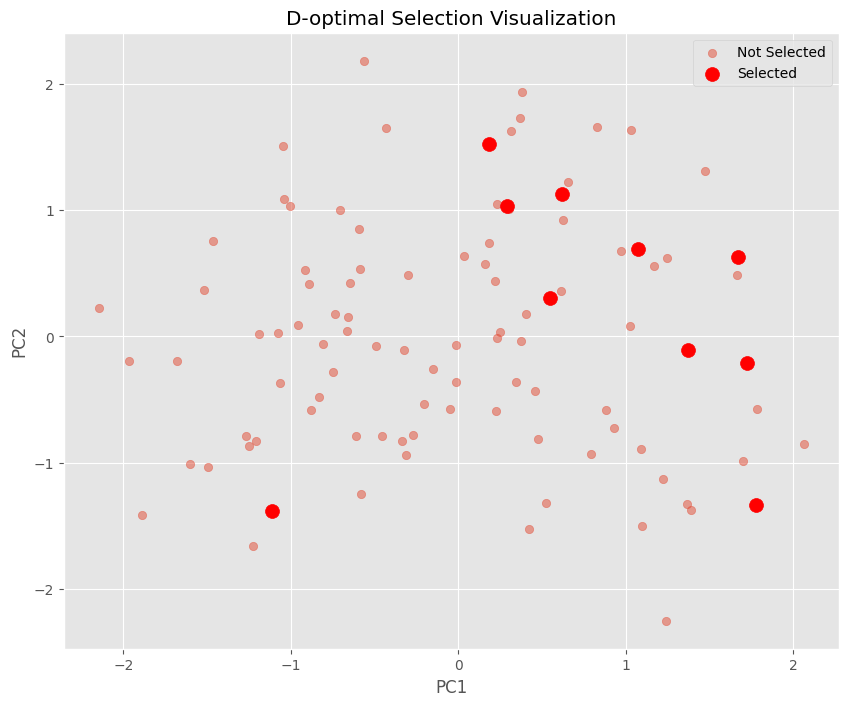

In [3]:
from sklearn.decomposition import PCA

# Use PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
M_reduced = pca.fit_transform(M)

# Create a mask for selected samples
selected_mask = np.zeros(n_samples, dtype=bool)
selected_mask[result.selected_indices[0]] = True

# Plot the samples in 2D space
plt.figure(figsize=(10, 8))
plt.scatter(M_reduced[~selected_mask, 0], M_reduced[~selected_mask, 1], alpha=0.5, label="Not Selected")
plt.scatter(M_reduced[selected_mask, 0], M_reduced[selected_mask, 1], color="red", s=100, label="Selected")
plt.title("D-optimal Selection Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

## 2. Ordered Selection for TSP-like Problems

In [4]:
# Generate a random distance matrix for a TSP-like problem
n_cities = 15  # Reduced for faster execution
#np.random.seed(42)
city_coords = np.random.rand(n_cities, 2) * 100  # Random coordinates in 2D space

# Calculate distances between cities
dist_matrix = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    for j in range(n_cities):
        dist_matrix[i, j] = np.sqrt(np.sum((city_coords[i] - city_coords[j])**2))

# Convert to a form that TrainSelPy can use
dist_df = pd.DataFrame(dist_matrix)

# Create a data object for TrainSelPy
ts_data = {"DistMat": dist_df}

# Define a TSP fitness function (minimize total distance)
def tsp_fitness(solution, data):
    """Calculate the negative total tour distance."""
    dist_mat = data["DistMat"]
    total_dist = 0
    
    # Calculate total tour distance including return to start
    for i in range(len(solution)):
        from_city = solution[i]
        to_city = solution[(i + 1) % len(solution)]
        total_dist += dist_mat.iloc[from_city, to_city]
    
    # Return negative distance (as TrainSelPy maximizes by default)
    return -total_dist

# Set control parameters
control = set_control_default()
control["niterations"] = 500
control["npop"] = 400
control["mutprob"] = 0.3
control["crossprob"] = 0.5

# Run the TSP optimization
start_time = time.time()
result_tsp = train_sel(
    data=ts_data,
    candidates=[list(range(n_cities))],
    setsizes=[n_cities],  # Select all cities (full tour)
    settypes=["OS"],      # Ordered set (the order matters)
    stat=tsp_fitness,
    control=control,
    verbose=True
)
runtime = time.time() - start_time

print(f"\nTSP optimization completed in {runtime:.2f} seconds")
print(f"Tour length: {-result_tsp.fitness:.2f} units")
print(f"Tour: {result_tsp.selected_indices[0]}")

Starting TrainSelPy optimization
Starting GA with population size 400
Initial best fitness: -667.4172570057417
Generation 0: Best fitness = -598.527305876768
Generation 10: Best fitness = -524.4176424133312
Generation 20: Best fitness = -492.5738970550325
Generation 30: Best fitness = -467.79312323232693
Generation 40: Best fitness = -467.79312323232693
Generation 50: Best fitness = -447.73730613814536
Generation 60: Best fitness = -437.7140550110103
Generation 70: Best fitness = -437.7140550110103
Generation 80: Best fitness = -437.7140550110103
Generation 90: Best fitness = -437.7140550110103
Generation 100: Best fitness = -437.7140550110103
Generation 110: Best fitness = -437.3779747591441
Generation 120: Best fitness = -432.2197539524452
Generation 130: Best fitness = -432.2197539524452
Generation 140: Best fitness = -418.2771912603031
Generation 150: Best fitness = -418.2771912603031
Generation 160: Best fitness = -414.759854644785
Generation 170: Best fitness = -414.759854644785


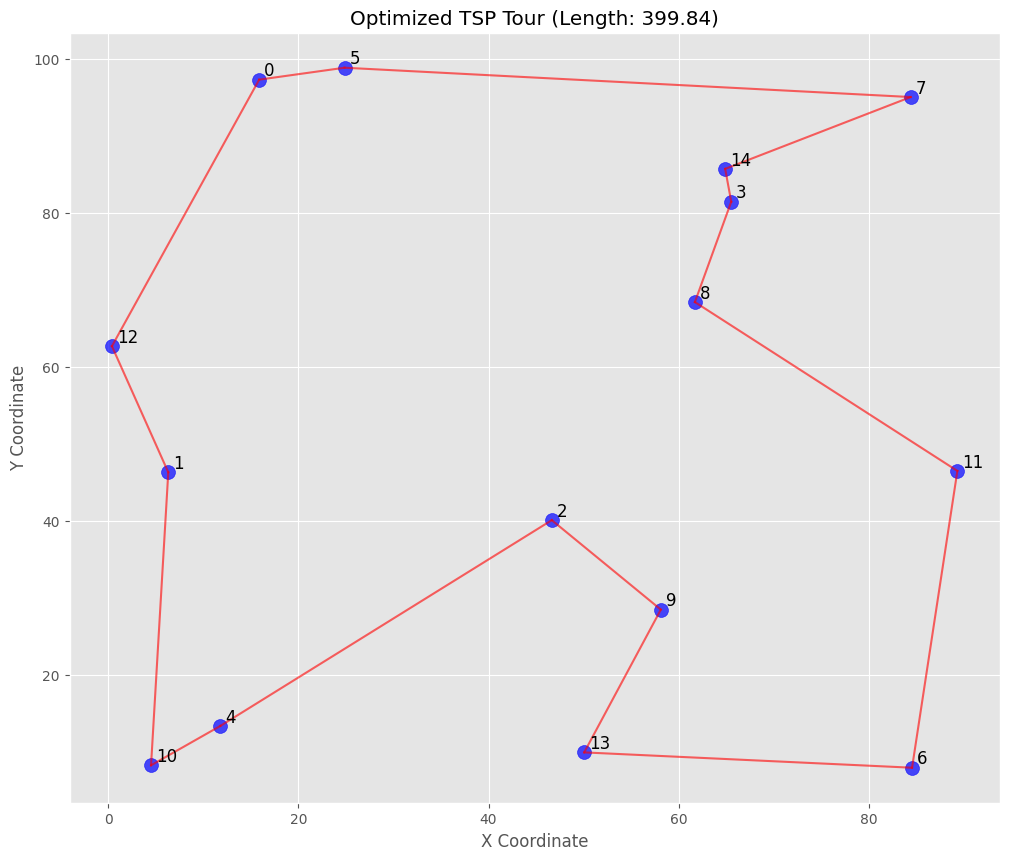

In [5]:
# Get the optimized tour
tour = result_tsp.selected_indices[0]

# Plot the tour
plt.figure(figsize=(12, 10))
plt.scatter(city_coords[:, 0], city_coords[:, 1], s=100, c='blue', alpha=0.7)

# Add city labels
for i in range(n_cities):
    plt.text(city_coords[i, 0] + 0.5, city_coords[i, 1] + 0.5, str(i), fontsize=12)

# Plot the tour path
for i in range(len(tour)):
    from_city = tour[i]
    to_city = tour[(i + 1) % len(tour)]
    plt.plot([city_coords[from_city, 0], city_coords[to_city, 0]],
             [city_coords[from_city, 1], city_coords[to_city, 1]], 'r-', alpha=0.6)

plt.title(f"Optimized TSP Tour (Length: {-result_tsp.fitness:.2f})")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

## 3. Mixed Integer Problem: Item Selection with Weights

In [6]:
# Define a mixed integer problem
# - Select 5 items from a set of 20
# - Assign continuous weights (0-1) to each selected item
# - Maximize a weighted sum function

n_items = 20
n_select = 5
n_weights = n_select

# Create random item values
np.random.seed(123)
item_values = np.random.rand(n_items) * 10
item_costs = np.random.rand(n_items) * 5

# Create data object
mixed_data = {
    "values": item_values,
    "costs": item_costs,
    "budget": 10.0  # Maximum total cost
}

# Define mixed integer fitness function
def mixed_integer_fitness(int_solution, dbl_solution, data):
    """Fitness function for mixed integer problem."""
    selected_items = int_solution
    weights = dbl_solution
    
    # Normalize weights to sum to 1
    weights = np.array(weights) / np.sum(weights)
    
    # Calculate total value and cost
    total_value = np.sum(data["values"][selected_items] * weights)
    total_cost = np.sum(data["costs"][selected_items] * weights)
    
    # Apply penalty if over budget
    if total_cost > data["budget"]:
        penalty = (total_cost - data["budget"]) * 20
        return total_value - penalty
    
    return total_value

# Set control parameters
control = set_control_default()
control["niterations"] = 30
control["npop"] = 100

# Run the mixed integer optimization
result_mixed = train_sel(
    data=mixed_data,
    candidates=[
        list(range(n_items)),  # Integer candidates
        list(range(n_weights))  # Just placeholder for continuous vars
    ],
    setsizes=[n_select, n_weights],
    settypes=["UOS", "DBL"],  # UOS for items, DBL for weights
    stat=mixed_integer_fitness,
    control=control,
    verbose=True
)

# Get results
selected_items = result_mixed.selected_indices[0]
selected_weights_raw = result_mixed.selected_values[0]
selected_weights = np.array(selected_weights_raw) / np.sum(selected_weights_raw)

# Calculate final metrics
total_value = np.sum(item_values[selected_items] * selected_weights)
total_cost = np.sum(item_costs[selected_items] * selected_weights)

print(f"\nSelected items: {selected_items}")
print(f"Normalized weights: {selected_weights}")
print(f"Total value: {total_value:.2f}")
print(f"Total cost: {total_cost:.2f} (Budget: {mixed_data['budget']})")

Starting TrainSelPy optimization
Starting GA with population size 100
Initial best fitness: 7.506402224201283
Initialized CMA-ES for continuous variables (sigma=0.2)
Generation 0: Best fitness = 7.506402224201283
Generation 10: Best fitness = 9.000048509168819
Generation 20: Best fitness = 9.69033912842276
Optimization completed in 0.36 seconds
Final fitness: 9.807641983846155

Selected items: [1, 4, 6, 15, 16]
Normalized weights: [0. 0. 1. 0. 0.]
Total value: 9.81
Total cost: 1.81 (Budget: 10.0)


All Items:


,Item,Value,Cost,Value/Cost,Selected
0,0,6.964692,3.172005,2.195675,No
1,1,2.861393,4.247159,0.673719,Yes
2,2,2.268515,3.622277,0.626268,No
3,3,5.513148,3.055118,1.804562,No
4,4,7.194690,3.612217,1.991766,Yes
5,5,4.231065,1.614795,2.620188,No
6,6,9.807642,1.808943,5.421752,Yes
7,7,6.848297,1.141316,6.000351,No
8,8,4.809319,1.468570,3.274831,No
9,9,3.921175,3.154881,1.242892,No



Selected Items:


,Item,Value,Cost,Weight,Weighted Value,Weighted Cost
0,1,2.861393,4.247159,0.0,0.000000,0.000000
1,4,7.194690,3.612217,0.0,0.000000,0.000000
2,6,9.807642,1.808943,1.0,9.807642,1.808943
3,15,7.379954,1.561306,0.0,0.000000,0.000000
4,16,1.824917,2.131757,0.0,0.000000,0.000000


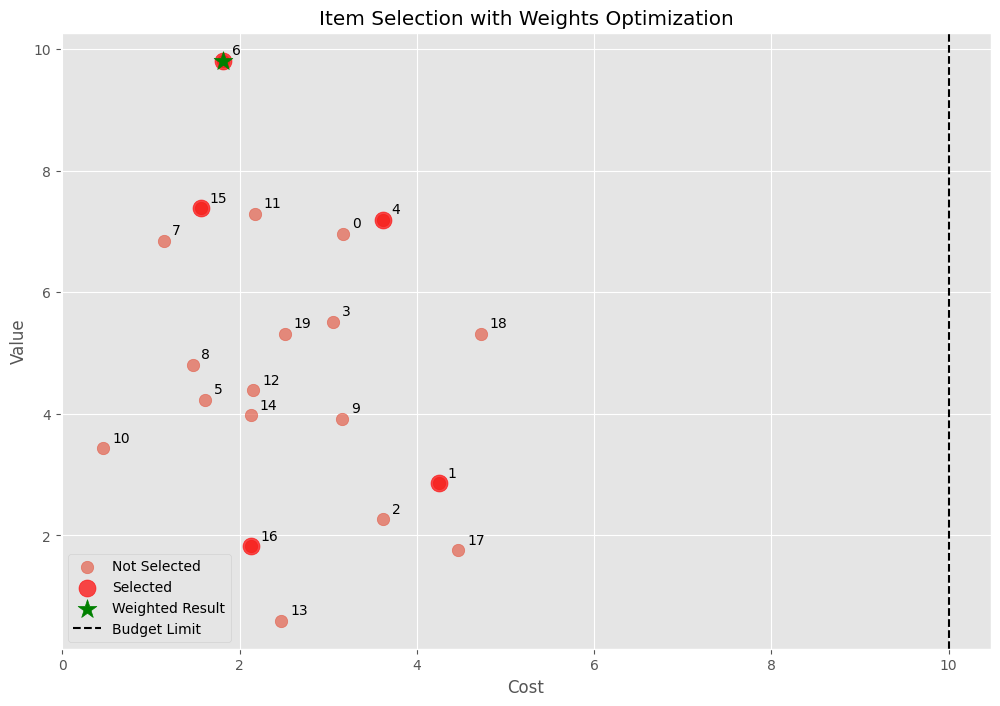

In [7]:
# Create a dataframe with all items
all_items_df = pd.DataFrame({
    'Item': range(n_items),
    'Value': item_values,
    'Cost': item_costs,
    'Value/Cost': item_values / item_costs,
    'Selected': ['Yes' if i in selected_items else 'No' for i in range(n_items)]
})

# Create a dataframe with just the selected items and their weights
selected_df = pd.DataFrame({
    'Item': selected_items,
    'Value': item_values[selected_items],
    'Cost': item_costs[selected_items],
    'Weight': selected_weights,
    'Weighted Value': item_values[selected_items] * selected_weights,
    'Weighted Cost': item_costs[selected_items] * selected_weights
})

# Display the dataframes
print("All Items:")
display(all_items_df)

print("\nSelected Items:")
display(selected_df)

# Visualize the value-cost tradeoff
plt.figure(figsize=(12, 8))
plt.scatter(item_costs, item_values, s=80, alpha=0.6, label="Not Selected")
plt.scatter(item_costs[selected_items], item_values[selected_items], s=150, c='red', alpha=0.7, label="Selected")

# Add item labels
for i in range(n_items):
    plt.text(item_costs[i] + 0.1, item_values[i] + 0.1, str(i), fontsize=10)

# Add weighted positions
weighted_cost = np.sum(item_costs[selected_items] * selected_weights)
weighted_value = np.sum(item_values[selected_items] * selected_weights)
plt.scatter([weighted_cost], [weighted_value], s=200, c='green', marker='*', label="Weighted Result")

plt.axvline(x=mixed_data['budget'], color='black', linestyle='--', label="Budget Limit")

plt.title("Item Selection with Weights Optimization")
plt.xlabel("Cost")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

## 4. Custom Optimization Criteria

In [8]:
# Create a dataset for custom optimization
n_samples = 100
n_features = 30

np.random.seed(42)
# Create a marker matrix
M_custom = np.random.choice([-1, 0, 1], size=(n_samples, n_features), p=[0.25, 0.5, 0.25])

# Calculate distance matrix
from scipy.spatial.distance import pdist, squareform
dist_matrix = squareform(pdist(M_custom))

# Create a TrainSel data object
ts_data_custom = make_data(M=M_custom)
ts_data_custom["FeatureMat"] = M_custom
ts_data_custom["DistMat"] = pd.DataFrame(dist_matrix)

# Define a custom optimization function combining D-optimality and maximin criteria
def custom_composite_criterion(solution, data):
    """Custom criterion combining D-optimality and diversity."""
    # Calculate D-optimality
    dopt_value = dopt(solution, data)
    
    # Calculate maximin criterion (diversity)
    maximin_value = maximin_opt(solution, data)
    
    # Scale the objectives to make them comparable
    # We're aiming to maximize both
    scaled_dopt = dopt_value / 100  # Scale down D-optimality to match maximin range
    
    # Return weighted combination (can adjust weights to emphasize one objective more)
    return 0.7 * scaled_dopt + 0.3 * maximin_value

# Run the optimization with the custom criterion
result_custom = train_sel(
    data=ts_data_custom,
    candidates=[list(range(n_samples))],
    setsizes=[15],
    settypes=["UOS"],
    stat=custom_composite_criterion,
    control=set_control_default(),
    verbose=True
)

# Calculate individual criteria values for the solution
selected = result_custom.selected_indices[0]
dopt_val = dopt(selected, ts_data_custom)
maximin_val = maximin_opt(selected, ts_data_custom)

print(f"\nSelected {len(selected)} samples: {selected}")
print(f"Composite fitness: {result_custom.fitness:.6f}")
print(f"D-optimality: {dopt_val:.6f}")
print(f"Maximin diversity: {maximin_val:.6f}")

Starting TrainSelPy optimization
Starting GA with population size 1000
Initial best fitness: -0.7095027668396776
Generation 0: Best fitness = -0.7095027668396776
Generation 10: Best fitness = -0.670122199750548
Generation 20: Best fitness = -0.6087440966858477
Generation 30: Best fitness = -0.6024100291563304
Generation 40: Best fitness = -0.5457633770480863
Generation 50: Best fitness = -0.5457633770480863
Generation 60: Best fitness = -0.5457633770480863
Generation 70: Best fitness = -0.5457633770480863
Generation 80: Best fitness = -0.5457633770480863
Generation 90: Best fitness = -0.5402581885429842
Generation 100: Best fitness = -0.5398687483827225
Generation 110: Best fitness = -0.5383915945091686
Generation 120: Best fitness = -0.5375316444660483
Generation 130: Best fitness = -0.5375316444660483
Generation 140: Best fitness = -0.5375316444660483
Generation 150: Best fitness = -0.5375316444660483
Generation 160: Best fitness = -0.5375316444660483
Generation 170: Best fitness = -


Running optimization with D-optimality criterion...
Starting GA with population size 1000
Initial best fitness: -306.0727883601545
Generation 0: Best fitness = -305.9443369202693
Generation 10: Best fitness = -304.5515370393367
Generation 20: Best fitness = -303.92263432832476
  Fitness: -303.391405

Running optimization with Maximin criterion...
Starting GA with population size 1000
Initial best fitness: 4.69041575982343
Generation 0: Best fitness = 4.69041575982343
Generation 10: Best fitness = 4.898979485566356
Generation 20: Best fitness = 5.0
  Fitness: 5.000000

Running optimization with Composite criterion...
Starting GA with population size 1000
Initial best fitness: -0.7732818626500675
Generation 0: Best fitness = -0.7063993037172822
Generation 10: Best fitness = -0.6449753429192553
Generation 20: Best fitness = -0.60338008720463
  Fitness: -0.601521

Comparison of different criteria:


,Criterion,D-optimality,Maximin
0,D-optimality,-303.391405,5.291503
1,Maximin,-306.546564,5.000000
2,Composite,-304.460940,5.099020


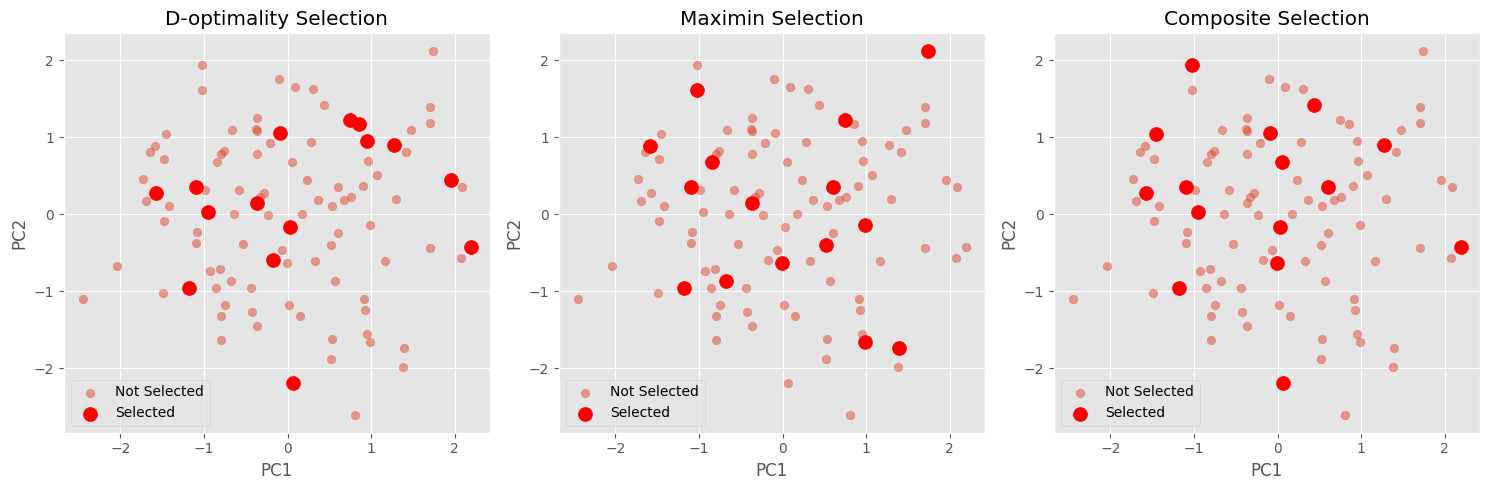

In [9]:
# Compare different criteria on the same dataset
criteria = [
    ("D-optimality", dopt),
    ("Maximin", maximin_opt),
    ("Composite", custom_composite_criterion)
]

results = {}

for name, criterion in criteria:
    print(f"\nRunning optimization with {name} criterion...")
    
    control = set_control_default()
    control["niterations"] = 30  # Reduced for demonstration
    
    result = train_sel(
        data=ts_data_custom,
        candidates=[list(range(n_samples))],
        setsizes=[15],
        settypes=["UOS"],
        stat=criterion,
        control=control,
        verbose=False
    )
    
    selected = result.selected_indices[0]
    results[name] = {
        "selected": selected,
        "fitness": result.fitness,
        "dopt": dopt(selected, ts_data_custom),
        "maximin": maximin_opt(selected, ts_data_custom)
    }
    
    print(f"  Fitness: {result.fitness:.6f}")

# Create a comparison table
comparison_df = pd.DataFrame({
    'Criterion': [name for name, _ in criteria],
    'D-optimality': [results[name]['dopt'] for name, _ in criteria],
    'Maximin': [results[name]['maximin'] for name, _ in criteria]
})

print("\nComparison of different criteria:")
display(comparison_df)

# Visualize the results using PCA
pca = PCA(n_components=2)
M_reduced = pca.fit_transform(M_custom)

plt.figure(figsize=(15, 5))

for i, (name, _) in enumerate(criteria):
    plt.subplot(1, 3, i+1)
    
    selected = results[name]['selected']
    selected_mask = np.zeros(n_samples, dtype=bool)
    selected_mask[selected] = True
    
    plt.scatter(M_reduced[~selected_mask, 0], M_reduced[~selected_mask, 1], alpha=0.5, label="Not Selected")
    plt.scatter(M_reduced[selected_mask, 0], M_reduced[selected_mask, 1], color="red", s=100, label="Selected")
    
    plt.title(f"{name} Selection")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Balancing Genetic Gain and Diversity

This example demonstrates how to balance genetic gain and diversity in a breeding context.

In [10]:
# Create a simulated breeding population dataset
n_individuals = 100
n_markers = 50

np.random.seed(123)
# Simulate marker data
M = np.random.choice([-1, 0, 1], size=(n_individuals, n_markers), p=[0.25, 0.5, 0.25])

# Create a relationship matrix (genomic relationships)
K = np.dot(M, M.T) / n_markers

# Add small diagonal value for numerical stability
K += np.eye(n_individuals) * 1e-6

# Simulate breeding values
breeding_values = np.random.normal(0, 1, size=n_individuals)
breeding_values = breeding_values * 10 + 100  # Scale for better visualization

# Create data object
breeding_data = {
    "breeding_values": breeding_values,
    "K": K
}

# Define a function that balances genetic gain and diversity
def balanced_selection(solution, data):
    """Objective function balancing genetic gain and diversity."""
    breeding_values = data["breeding_values"]
    K = data["K"]
    
    # Calculate genetic gain (mean breeding value of selected individuals)
    genetic_gain = np.mean(breeding_values[solution])
    
    # Calculate inbreeding (mean relationship coefficient among selected)
    selected_K = K[np.ix_(solution, solution)]
    # Get off-diagonal elements (relationships between different individuals)
    mask = ~np.eye(selected_K.shape[0], dtype=bool)
    inbreeding = np.mean(selected_K[mask])
    
    # Balance the two objectives (maximize gain, minimize inbreeding)
    # Scale genetic gain to be roughly in the same range as inbreeding
    scaled_gain = (genetic_gain - 90) / 20  # Assuming breeding values around 100
    
    # Weighted combination
    return 0.7 * scaled_gain - 0.3 * inbreeding

# Set control parameters
control = set_control_default()
control["niterations"] = 30
control["npop"] = 150

# Run the optimization
result_balanced = train_sel(
    data=breeding_data,
    candidates=[list(range(n_individuals))],
    setsizes=[10],  # Select 10 individuals
    settypes=["UOS"],
    stat=balanced_selection,
    control=control,
    verbose=True
)

# Print the selected individuals
selected = result_balanced.selected_indices[0]
print(f"\nSelected individuals: {selected}")
print(f"Fitness: {result_balanced.fitness:.4f}")

# Calculate the individual components
genetic_gain = np.mean(breeding_values[selected])
selected_K = K[np.ix_(selected, selected)]
mask = ~np.eye(selected_K.shape[0], dtype=bool)
inbreeding = np.mean(selected_K[mask])

print(f"Genetic gain: {genetic_gain:.4f}")
print(f"Average inbreeding: {inbreeding:.4f}")

Starting TrainSelPy optimization
Starting GA with population size 150
Initial best fitness: 0.669047450819404
Generation 0: Best fitness = 0.7506865268276124
Generation 10: Best fitness = 0.9234821262842912
Generation 20: Best fitness = 1.0126926295334662
Optimization completed in 0.44 seconds
Final fitness: 1.0150154845070332

Selected individuals: [3, 4, 21, 36, 45, 49, 54, 65, 71, 86]
Fitness: 1.0150
Genetic gain: 119.0271
Average inbreeding: 0.0031


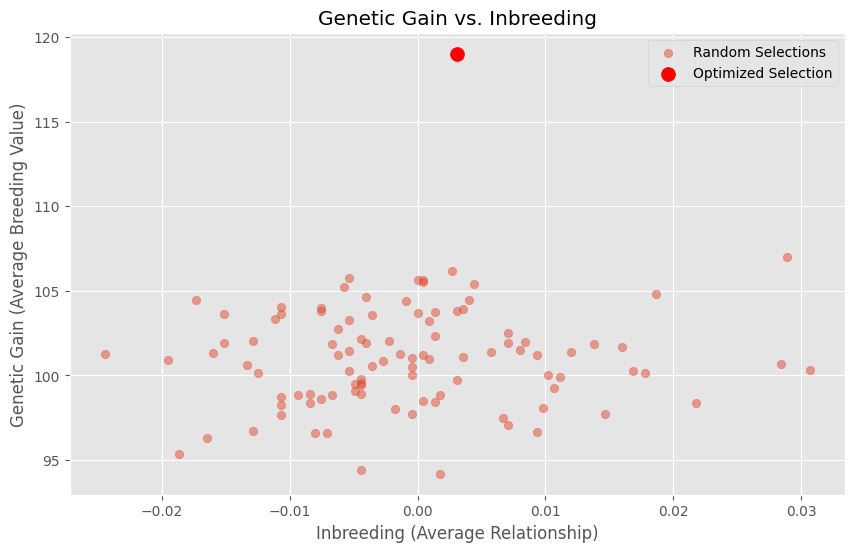

In [11]:
# Compare with random selections
n_random = 100
random_gains = []
random_inbreedings = []

for _ in range(n_random):
    random_selection = np.random.choice(n_individuals, size=10, replace=False)
    
    # Calculate gain
    gain = np.mean(breeding_values[random_selection])
    random_gains.append(gain)
    
    # Calculate inbreeding
    sel_K = K[np.ix_(random_selection, random_selection)]
    mask = ~np.eye(sel_K.shape[0], dtype=bool)
    inb = np.mean(sel_K[mask])
    random_inbreedings.append(inb)

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.scatter(random_inbreedings, random_gains, alpha=0.5, label="Random Selections")
plt.scatter([inbreeding], [genetic_gain], color='red', s=100, label="Optimized Selection")

plt.title("Genetic Gain vs. Inbreeding")
plt.xlabel("Inbreeding (Average Relationship)")
plt.ylabel("Genetic Gain (Average Breeding Value)")
plt.legend()
plt.grid(True)
plt.show()

## 6. Mixed Integer Optimization with Breeding Application

This example shows how to optimize both individual selection and their contributions in a breeding program.

In [12]:
# Define a function for optimal contribution selection
def optimal_contributions(int_sol, dbl_sol, data):
    """Calculate a combined objective for gain and inbreeding with contribution proportions."""
    # Normalize the contributions (proportions)
    props = np.array(dbl_sol) / np.sum(dbl_sol)
    
    breeding_values = data["breeding_values"]
    K = data["K"]
    
    # Weighted genetic gain
    genetic_gain = np.sum(breeding_values[int_sol] * props)
    
    # Expected inbreeding (quadratic form: p'Kp)
    selected_K = K[np.ix_(int_sol, int_sol)]
    inbreeding = props.T @ selected_K @ props
    
    # Combine objectives (with appropriate scaling)
    scaled_gain = (genetic_gain - 90) / 20
    return 0.7 * scaled_gain - 0.3 * inbreeding

# Optimize both selection and contributions
result_ocs = train_sel(
    data=breeding_data,
    candidates=[
        list(range(n_individuals)),  # Integer candidates
        list(range(5))               # Just placeholder for 5 continuous variables
    ],
    setsizes=[5, 5],                 # Select 5 individuals with 5 contribution values
    settypes=["UOS", "DBL"],         # UOS for individuals, DBL for contributions
    stat=optimal_contributions,
    control=control,
    verbose=True
)

# Print results
selected_inds = result_ocs.selected_indices[0]
contribution_raw = result_ocs.selected_values[0]
contributions = np.array(contribution_raw) / np.sum(contribution_raw)

print(f"\nSelected individuals: {selected_inds}")
print(f"Contributions: {contributions}")

# Calculate final metrics
genetic_gain = np.sum(breeding_values[selected_inds] * contributions)
selected_K = K[np.ix_(selected_inds, selected_inds)]
inbreeding = contributions.T @ selected_K @ contributions

print(f"Genetic gain: {genetic_gain:.4f}")
print(f"Expected inbreeding: {inbreeding:.4f}")

Starting TrainSelPy optimization
Starting GA with population size 150
Initial best fitness: 0.7478612954064504
Initialized CMA-ES for continuous variables (sigma=0.2)
Generation 0: Best fitness = 0.8611334860847618
Generation 10: Best fitness = 1.1201760204621571
Generation 20: Best fitness = 1.1438119428687399
Optimization completed in 0.46 seconds
Final fitness: 1.1443474613838363

Selected individuals: [4, 49, 54, 65, 71]
Contributions: [0.46665521 0.         0.11271008 0.42063471 0.        ]
Genetic gain: 123.8775
Expected inbreeding: 0.1379


## Conclusion

This vignette has demonstrated the core features of TrainSelPy with reliable examples:

1. **Unordered Subset Selection**: Optimal selection using D-optimality
2. **Ordered Subset Selection**: Traveling salesman problem optimization
3. **Mixed Integer Problems**: Item selection with weights optimization
4. **Custom Optimization Criteria**: Creating custom objective functions
5. **Breeding Applications**: Balancing genetic gain and diversity
6. **Optimal Contribution Selection**: Mixed integer optimization for breeding

These examples demonstrate TrainSelPy's capabilities for a wide range of optimization problems.